In [258]:
%pip install scikit-learn==1.3.2
%pip install skfeature-chappers
%pip install mlxtend 
%pip install pydataset
%pip install xgboost
%pip install pyswisseph
%pip install pyqt6
%pip install keras-tuner 
%pip install scikeras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data = pd.read_csv('train.csv', sep=',')

id = train_data['ID']
tank_failure_pressure= train_data['Tank Failure Pressure (bar)']
liquid_ratio = train_data['Liquid Ratio (%)']
tank_width = train_data['Tank Width (m)']
tank_length = train_data['Tank Length (m)']
tank_height = train_data['Tank Height (m)']
bleve_height = train_data['BLEVE Height (m)']
vapour_height = train_data['Vapour Height (m)']
vapour_temperature = train_data['Vapour Temperature (K)']
liquid_temperature = train_data['Liquid Temperature (K)']
obstacle_distance = train_data['Obstacle Distance to BLEVE (m)']
obstacle_width = train_data['Obstacle Width (m)']
obstacle_height = train_data['Obstacle Height (m)']
obstacle_thickness = train_data['Obstacle Thickness (m)']
obstacle_angle = train_data['Obstacle Angle']
status = train_data['Status']
liquid_critical_pressure = train_data['Liquid Critical Pressure (bar)']
liquid_boiling_temperature = train_data['Liquid Boiling Temperature (K)']
liquid_critical_temperature = train_data['Liquid Critical Temperature (K)']
sensor_id = train_data['Sensor ID']
sensor_position_side = train_data['Sensor Position Side']
sensor_position_x = train_data['Sensor Position x']
sensor_position_y = train_data['Sensor Position y']
sensor_position_z = train_data['Sensor Position z']
target_pressure = train_data['Target Pressure (bar)']

'''
Data preprocessing Step 1
- Feature Selection
- Feature Engineering
'''

tank_volume = tank_length * tank_width * tank_height
vapor_volume = (1 - liquid_ratio) * tank_volume
vapor_force = tank_failure_pressure * (vapour_height * tank_length)
sensor_distance_to_tank = np.sqrt((sensor_position_x - tank_length/2)**2 + (sensor_position_y - tank_width/2)**2 + (sensor_position_z - tank_height/2)**2)
tank_area = 2 * (tank_length * tank_width + tank_length * tank_height + tank_width * tank_height)
log_vapor_force = np.log(vapor_force)

obstacle_x = train_data['Obstacle Width (m)'] / 2
obstacle_y = train_data['Obstacle Height (m)'] / 2
obstacle_z = train_data['Obstacle Thickness (m)'] / 2
sensor_distance_to_obstacle_center = np.sqrt((sensor_position_x - obstacle_x)**2 
                                             + (sensor_position_y - obstacle_y)**2
                                             + (sensor_position_z - obstacle_z)**2)

sensor_distance_to_bleve = np.sqrt(sensor_distance_to_obstacle_center**2 + obstacle_distance**2)
interaction_sensor_pos_vapor_force = sensor_distance_to_tank * vapor_force

train_data['Vapor Volume'] = vapor_volume
train_data['Tank Volume'] = tank_volume
train_data['Vapor Force'] = vapor_force
train_data['Sensor Distance to Tank'] = sensor_distance_to_tank
train_data['Tank Area'] = tank_area
train_data['Sensor Distance to Obstacle Center'] = sensor_distance_to_obstacle_center
train_data['Sensor Distance to BLEVE'] = sensor_distance_to_bleve

train_data.drop(columns=['ID', 'Sensor ID'], inplace=True)

features_provided = len(train_data.columns)
print("Number of features provided: ", features_provided, "\n")

variance = train_data.var(numeric_only=True)
for column, var in variance.items():
    print(f"Variance of {column}: {var:.6g}")

Number of features provided:  30 

Variance of Tank Failure Pressure (bar): 50910.9
Variance of Liquid Ratio (%): 0.0520173
Variance of Tank Width (m): 0.585129
Variance of Tank Length (m): 6.7395
Variance of Tank Height (m): 0.5654
Variance of BLEVE Height (m): 0.331159
Variance of Vapour Height (m): 0.287873
Variance of Vapour Temperature (K): 5166.28
Variance of Liquid Temperature (K): 1262.84
Variance of Obstacle Distance to BLEVE (m): 16.2394
Variance of Obstacle Width (m): 15.4914
Variance of Obstacle Height (m): 13.6254
Variance of Obstacle Thickness (m): 0.551192
Variance of Obstacle Angle: 85.3246
Variance of Liquid Critical Pressure (bar): 5.28042
Variance of Liquid Boiling Temperature (K): 419.471
Variance of Liquid Critical Temperature (K): 763.178
Variance of Sensor Position Side: 1.78037
Variance of Sensor Position x: 17.2964
Variance of Sensor Position y: 22.206
Variance of Sensor Position z: 17.753
Variance of Target Pressure (bar): 0.245293
Variance of Vapor Volume: 48

Linear Regression

Number of numeric features:  29
Number of categorical features:  1
Number of missing values:  359
Number of duplicate rows:  50 



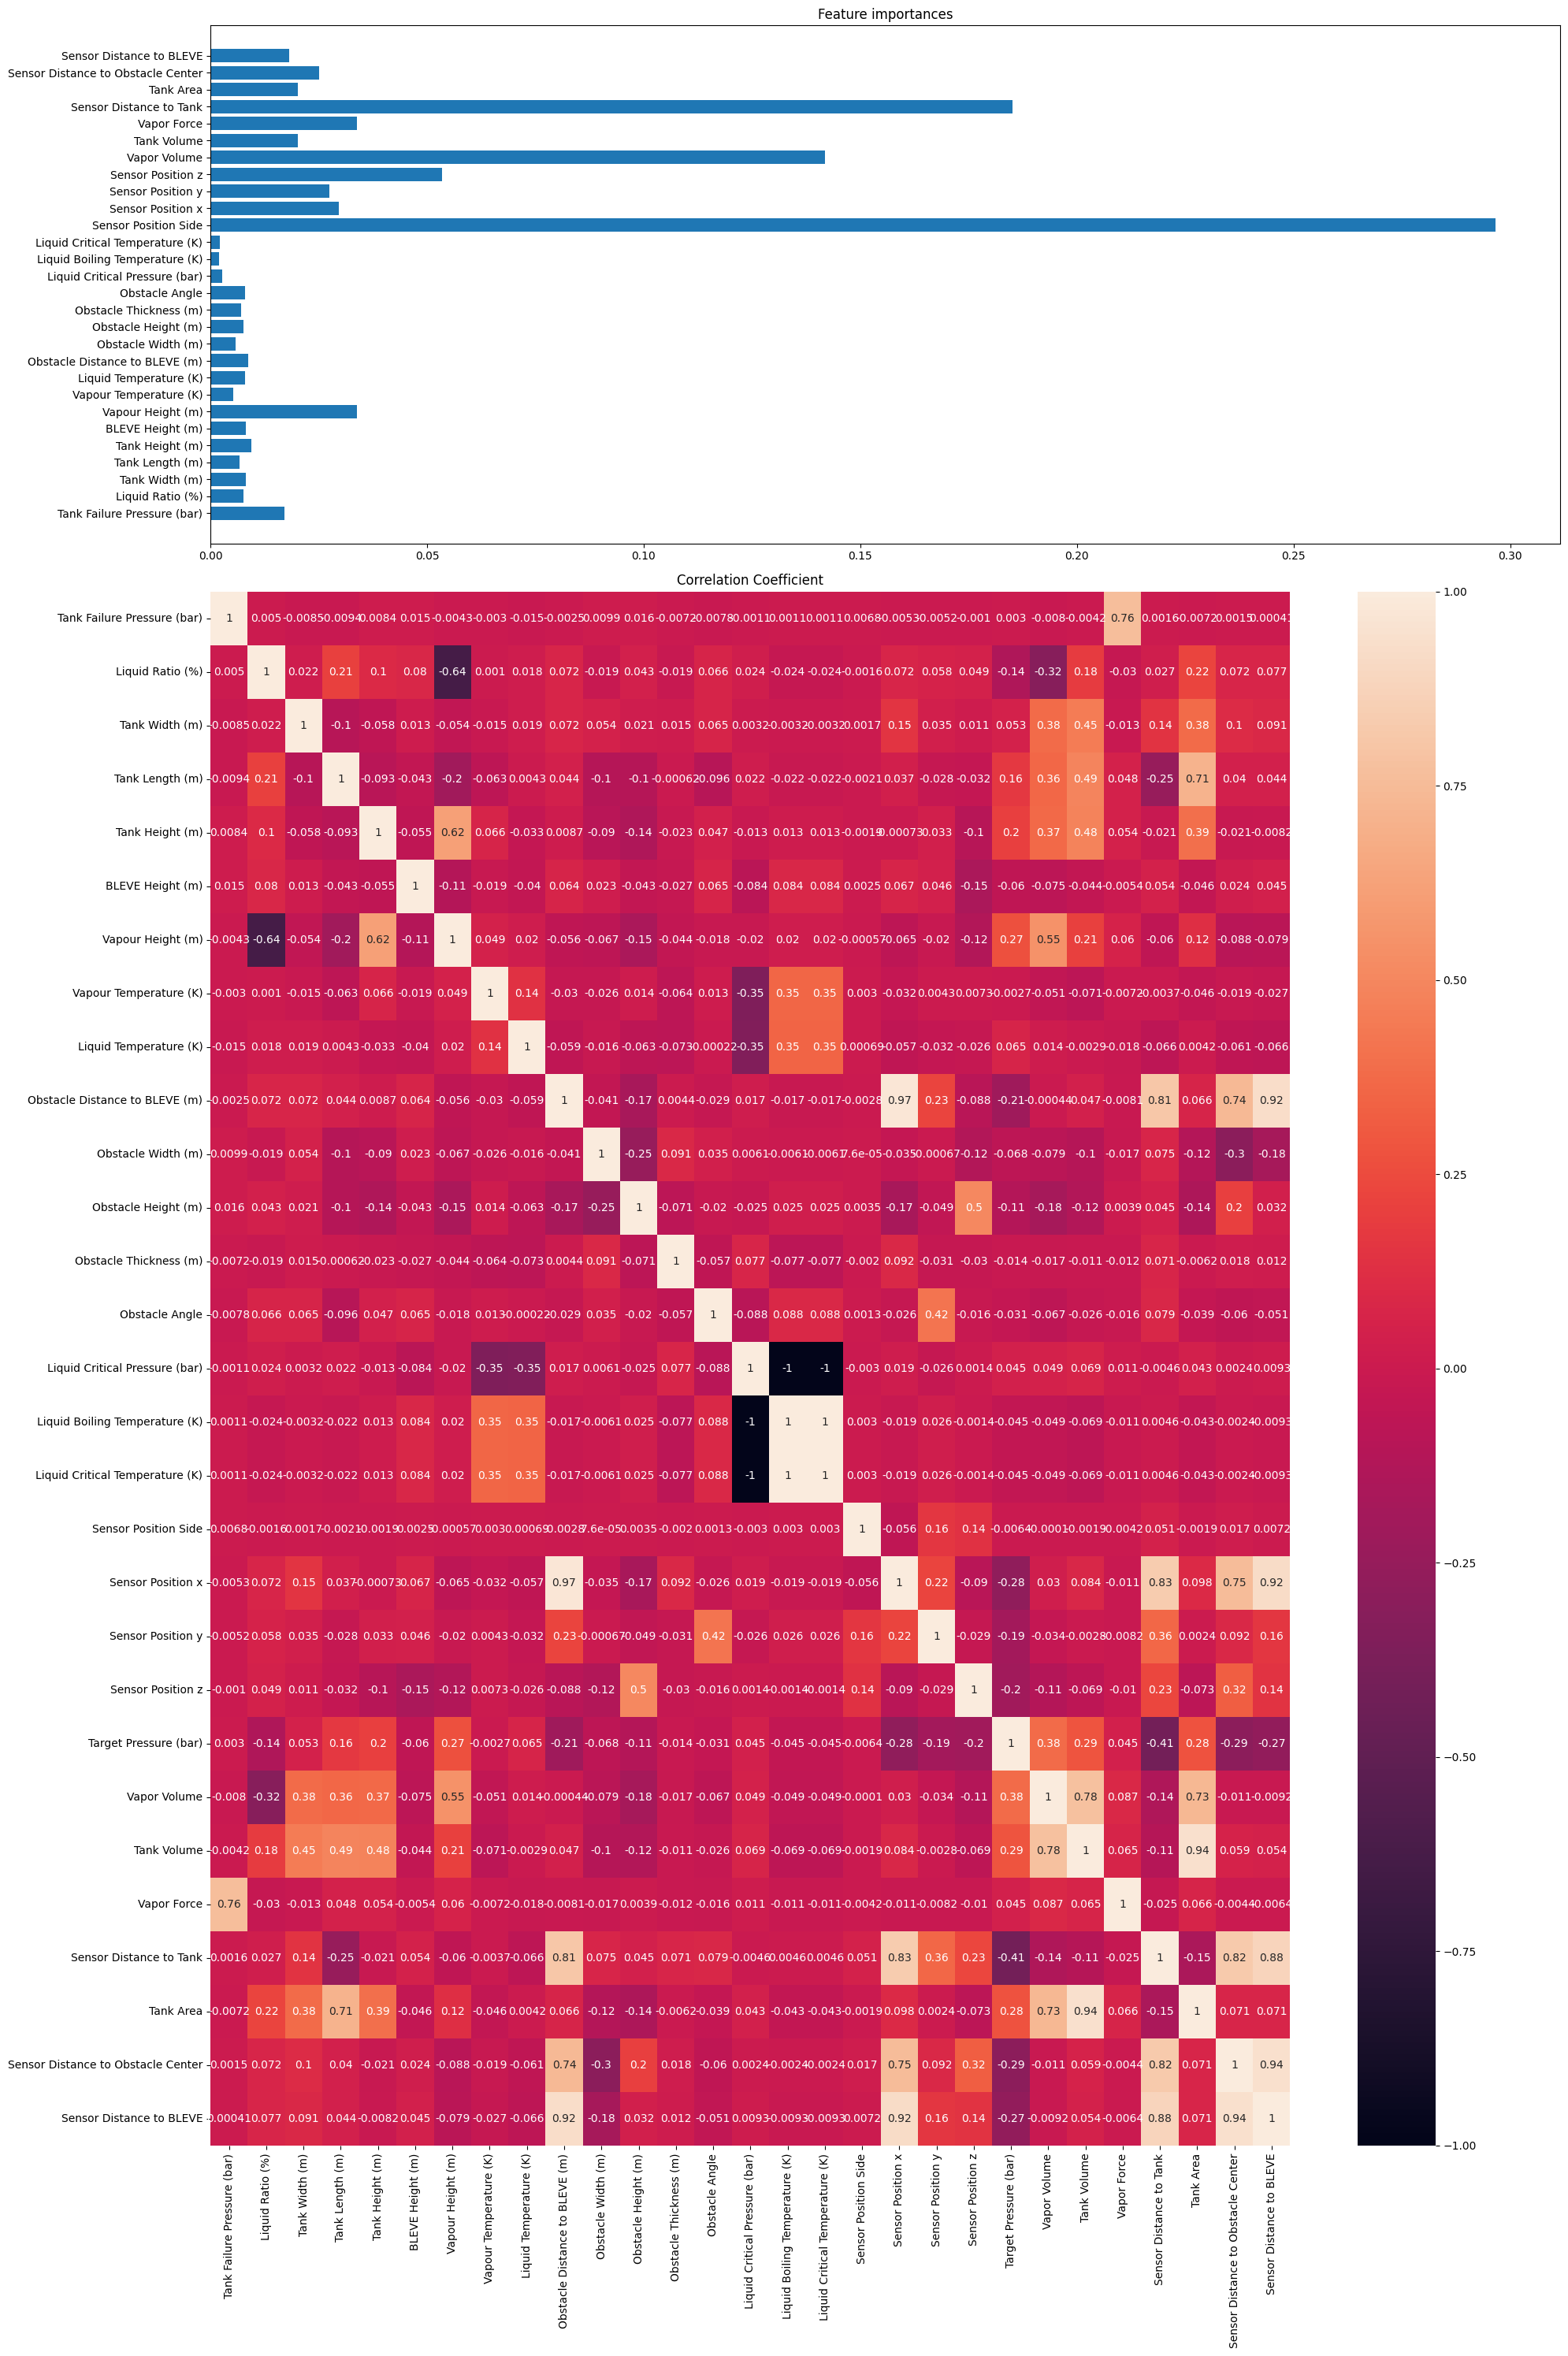

In [3]:
# Feature selection

from sklearn.feature_selection import mutual_info_regression
from skfeature.function.similarity_based import fisher_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
import seaborn as sns

numeric_features = train_data.select_dtypes(include=['number']).dropna().drop_duplicates()
categorical_features = train_data.select_dtypes(include=['object'])
missing_value_count = train_data.isna().sum()
duplicate_count = train_data.duplicated().sum()

print("Number of numeric features: ", len(numeric_features.columns))
print("Number of categorical features: ", len(categorical_features.columns))
print("Number of missing values: ", missing_value_count.sum())
print("Number of duplicate rows: ", duplicate_count, "\n")

X = numeric_features.drop(columns=['Target Pressure (bar)'], axis='columns')
Y = numeric_features['Target Pressure (bar)']

tree_regressor = ExtraTreesRegressor()
tree_regressor.fit(X, Y) 
feature_importances = pd.Series(tree_regressor.feature_importances_, X.columns)

correlation = numeric_features.corr()

fig, axs = plt.subplots(2, 1, figsize=(20, 30), gridspec_kw={'height_ratios': [1, 3]})

# Plot Feature importances
axs[0].barh(feature_importances.index, feature_importances)
axs[0].set_title("Feature importances")

# Plot Correlation coefficient heatmap
sns.heatmap(correlation, annot=True, ax=axs[1])
axs[1].set_title("Correlation Coefficient")

plt.tight_layout()
plt.show()


In [4]:
'''
Data preprocessing Step 2
- Normalize the data
- Encode the categorical data
'''

import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer, Normalizer
from scipy import stats

def encode_labels(data): 
    label_encoders = {}
    data_categorical = data.select_dtypes(include=['object'])
    data_numerical = data.select_dtypes(include=['number'])
    categorical_df = pd.DataFrame(index=data_categorical.index)
    
    for column in data_categorical:
        label_encoders[column] = LabelEncoder()
        categorical_df[column] = label_encoders[column].fit_transform(data_categorical.iloc[:, 0])
    
    return pd.concat([data_numerical, categorical_df], axis=1)


numeric_features = train_data.select_dtypes(include=['number']).dropna().drop_duplicates()
categorical_features = train_data.select_dtypes(include=['object'])

cleaned_data_for_nn = pd.concat([numeric_features, categorical_features], axis='columns').dropna().drop_duplicates()
X_nn = encode_labels(cleaned_data_for_nn)
X_nn = X_nn.drop(columns=['Target Pressure (bar)'], axis='columns')

nn_scaler = MinMaxScaler()
X_nn = pd.DataFrame(nn_scaler.fit_transform(X_nn), columns=X_nn.columns)
Y_nn = numeric_features['Target Pressure (bar)']

z_score = np.abs(stats.zscore(numeric_features))
threshold = 3
numeric_features = numeric_features[(z_score < threshold).all(axis=1)]

status_mappings = {
    "Subcooled": "Subcooled",
    "Subcool": "Subcooled",
    "subcooled": "Subcooled",
    "Subcoled": "Subcooled",
    "Superheated": "Superheated",
    "Superheat": "Superheated",
    "superheated": "Superheated",
    "Saperheated": "Superheated"
}

categorical_features['Status'].replace(status_mappings, inplace=True)

cleaned_data = pd.concat([numeric_features, categorical_features], axis='columns').dropna().drop_duplicates()
# cleaned_data = pd.concat([cleaned_data, categorical_features], axis='columns').dropna().drop_duplicates()

print('new data size ', cleaned_data.size, '   New data records : ', len(cleaned_data.index))
print('raw data size ', train_data.size, '   Raw data records : ', len(train_data.index))

X = cleaned_data.drop(columns=['Target Pressure (bar)'], axis='columns')
X = encode_labels(X)

x_min_max_scaler = MinMaxScaler()
scaled_X = x_min_max_scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X.columns)

Y = pd.DataFrame(cleaned_data['Target Pressure (bar)'], columns=['Target Pressure (bar)'])

new data size  279270    New data records :  9309
raw data size  301500    Raw data records :  10050


w from sklearn :  [ 2.68577311e-02  5.81990834e-04 -4.69892280e-02  1.03505323e-02
 -7.63361493e-03  6.46696694e-05  2.33827710e-03  2.88936133e-03
  1.62919186e-02  1.20379853e-02]
b from sklearn :  0.30606706343086004


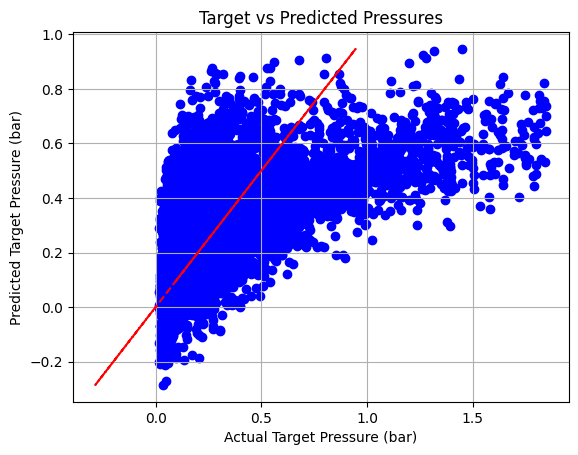

R squared : 0.33
Mean Absolute Percentage Error : 1.07
Mean Absolute Error : 0.18
Root Mean Squared Error : 0.25


In [262]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Multiple linear regression : 

x_train_lr = cleaned_data[[
    'Obstacle Distance to BLEVE (m)',
    'Vapor Force',
    'Sensor Distance to Tank',
    'Vapor Volume',
    'Sensor Position y',
    'Sensor Position z',
    'Obstacle Angle',
    'Liquid Critical Pressure (bar)',
    'Status',
    'Sensor Position Side'
]]
x_train_lr = encode_labels(x_train_lr)

y_train_lr = cleaned_data['Target Pressure (bar)']

linear_regression = LinearRegression().fit(x_train_lr, y_train_lr)

print('w from sklearn : ', linear_regression.coef_)
print('b from sklearn : ', linear_regression.intercept_)

predicted_values = linear_regression.predict(x_train_lr)

# Linear regression fit from sklearn predicted values vs Target values
plt.scatter(Y, predicted_values, color='blue', label='Target vs Predicted')
plt.plot(predicted_values, predicted_values, color='red', linestyle='--', label='Prediction line')
plt.title('Target vs Predicted Pressures')
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.grid(True)
plt.show()

r_square_score = linear_regression.score(x_train_lr, y_train_lr)
mape = mean_absolute_percentage_error(y_train_lr, predicted_values)
mean_absolute_error = mean_absolute_error(y_train_lr, predicted_values)
rmse = mean_squared_error(y_train_lr, predicted_values, squared=False)

print('R squared : {:.2f}'.format(r_square_score))
print('Mean Absolute Percentage Error : {:.2f}'.format(mape))
print('Mean Absolute Error : {:.2f}'.format(mean_absolute_error))
print('Root Mean Squared Error : {:.2f}'.format(rmse))


Gradient boost regresion

Depth: 1, Score: -0.07433547233279793
Depth: 2, Score: -0.057807043379653776
Depth: 3, Score: -0.04315406727001404
Depth: 4, Score: -0.03107184275071071
Depth: 5, Score: -0.026260050521067686
Depth: 6, Score: -0.022303020146130923
Depth: 7, Score: -0.019004579763947527
Depth: 8, Score: -0.0173390527846787
Depth: 9, Score: -0.016319934969145713
Depth: 10, Score: -0.01552268817134761


/Users/kalinduabeysinghe/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


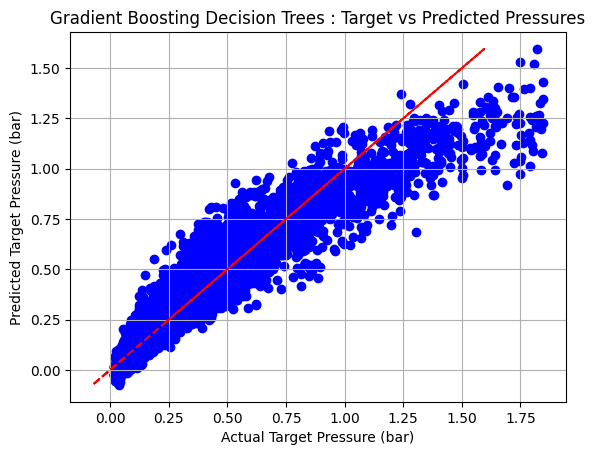


Gradient boosting regreesion R squared : 0.90
Gradient boosting Mean Absolute Percentage Error : 0.27
Gradient boosting Mean Absolute Error : 0.06
Gradient boosting Root Mean Squared Error : 0.10


In [7]:
# Gradient boosted regression

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pydataset import data
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

cross_validation = KFold(n_splits=10, shuffle=True, random_state=1)

for depth in range(1, 11) :
    tree_regressor = tree.DecisionTreeRegressor(max_depth = depth, random_state = 1, )
    if tree_regressor.fit(X, Y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_regressor, 
                                    X,
                                    Y, 
                                    scoring = 'neg_mean_squared_error',
                                    cv = cross_validation, 
                                    n_jobs = 1))
    print(f"Depth: {depth}, Score: {score}")
    
'''
The score tells you how well the decision tree regressor with a specific maximum depth performs in terms of 
predicting the target variable. Lower scores indicate better performance. 
By looking at the scores for different depths, you can determine which depth leads to the best model performance.
Choosing max depth of 7 by running cross validation above.
'''
gbr = GradientBoostingRegressor()
gbr.fit(X, Y)
gbr_predicted = gbr.predict(X)

r_square_score = gbr.score(X, Y)
mape = mean_absolute_percentage_error(Y, gbr_predicted)
mae = mean_absolute_error(Y, gbr_predicted)
rmse = mean_squared_error(Y, gbr_predicted, squared=False)

plt.scatter(Y, gbr_predicted, color='blue', label='Target vs Predicted')
plt.plot(gbr_predicted, gbr_predicted, color='red', linestyle='--', label='Prediction line')
plt.title('Gradient Boosting Decision Trees : Target vs Predicted Pressures')
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.grid(True)
plt.show()

print()
print('Gradient boosting regreesion R squared : {:.2f}'.format(r_square_score))
print('Gradient boosting Mean Absolute Percentage Error : {:.2f}'.format(mape))
print('Gradient boosting Mean Absolute Error : {:.2f}'.format(mae))
print('Gradient boosting Root Mean Squared Error : {:.2f}'.format(rmse))


In [264]:
# Gradient boosted regression hyper-parameter tuning

gbr = GradientBoostingRegressor()

search_grid = {
    'n_estimators': [200, 300, 600],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [7],
    'subsample' : [0.5, 0.75, 1],
    'random_state' : [1]
}
search = GridSearchCV(
    estimator=gbr,
    param_grid=search_grid,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv=cross_validation,
)

'''
The hyper parameter tune is commented out since it takes 2-3 hours to run. The results by running it once is below:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'random_state': 1, 'subsample': 0.75}
'''
# -0.014955239628021153
# search.fit(X, Y)
# print(search.best_params_)
# print(search.best_score_)

"\nThe hyper parameter tune is commented out since it takes 2-3 hours to run. The results by running it once is below:\n{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'random_state': 1, 'subsample': 0.75}\n"

In [5]:
# test.cv for Gradient boosted regression

test_data = pd.read_csv('test.csv', sep=',')

test_id = test_data['ID']
test_liquid_ratio = test_data['Liquid Ratio (%)']
test_tank_width = test_data['Liquid Ratio (%)']
test_tank_length = test_data['Tank Length (m)']
test_tank_height = test_data['Tank Height (m)']
test_tank_failure_pressure = test_data['Tank Failure Pressure (bar)']
test_vapour_height = test_data['Vapour Height (m)']
test_obstacle_height = test_data['Obstacle Height (m)']
test_obstacle_width = test_data['Obstacle Width (m)']
test_obstacle_angle = test_data['Obstacle Angle']
test_obstacle_thickness = test_data['Obstacle Thickness (m)']
test_vapor_temperature = test_data['Vapour Temperature (K)']
test_liquid_temperature = test_data['Liquid Temperature (K)']
test_sensor_position_x = test_data['Sensor Position x']
test_sensor_position_y = test_data['Sensor Position y']
test_sensor_position_z = test_data['Sensor Position z']
test_obstacle_distance = test_data['Obstacle Distance to BLEVE (m)']

test_tank_width_height_ratio = test_tank_width / test_tank_height
test_tank_volume = test_tank_length * test_tank_width * test_tank_height

test_tank_width_height_ratio = test_tank_width / test_tank_height
test_vapor_volume = (1 - test_liquid_ratio) * test_tank_volume

test_vapor_force = test_tank_failure_pressure * (test_vapour_height * test_tank_length)
test_projected_obstacle_area = test_obstacle_width * test_obstacle_height * np.cos(test_obstacle_angle)
test_obstacle_ratio = test_projected_obstacle_area / (test_tank_length)
test_volume_ratio = test_tank_volume / (test_obstacle_height * test_obstacle_width * test_obstacle_thickness)
test_vapor_density = test_vapor_volume / test_tank_volume
test_sensor_distance_to_ta = np.sqrt((test_sensor_position_x - test_tank_length/2)**2 + (test_sensor_position_y - test_tank_width/2)**2 + (test_sensor_position_z - test_tank_height/2)**2)
test_tank_area = 2 * (test_tank_length * test_tank_width + test_tank_length * test_tank_height + test_tank_width * test_tank_height)

test_obstacle_x = test_data['Obstacle Width (m)'] / 2
test_obstacle_y = test_data['Obstacle Height (m)'] / 2
test_obstacle_z = test_data['Obstacle Thickness (m)'] / 2
test_sensor_distance_to_obstacle_center = np.sqrt((test_sensor_position_x - test_obstacle_x)**2
                                                + (test_sensor_position_y - test_obstacle_y)**2
                                                + (test_sensor_position_z - test_obstacle_z)**2)
sensor_distance_to_bleve = np.sqrt(test_sensor_distance_to_obstacle_center**2 + test_obstacle_distance**2)
interaction_sensor_pos_vapor_force = test_sensor_distance_to_ta * test_vapor_force

test_data.drop(columns=['ID', 'Sensor ID'], inplace=True)

'''
Adding newly engineered features during traning into the test data set :
'''
test_data['Vapor Volume'] = test_vapor_volume
test_data['Tank Volume'] = test_tank_volume
test_data['Vapor Force'] = test_vapor_force
test_data['Sensor Distance to Tank'] = test_sensor_distance_to_ta
test_data['Tank Area'] = test_tank_area
test_data['Sensor Distance to Obstacle Center'] = test_sensor_distance_to_obstacle_center
test_data['Sensor Distance to BLEVE'] = sensor_distance_to_bleve


test_data = encode_labels(test_data)

scaled_test_data = x_min_max_scaler.fit_transform(test_data)
test_data = pd.DataFrame(scaled_test_data, columns=test_data.columns)

test_data_nn = pd.DataFrame(nn_scaler.fit_transform(test_data), columns=test_data.columns)

print('Train data columns size ', X.columns.size)
print('Train data columns ', X.columns)
print('Test data columns size ', test_data.columns.size)
print('Test data columns ', test_data.columns)




Train data columns size  29
Train data columns  Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)',
       'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)',
       'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
       'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle',
       'Liquid Critical Pressure (bar)', 'Liquid Boiling Temperature (K)',
       'Liquid Critical Temperature (K)', 'Sensor Position Side',
       'Sensor Position x', 'Sensor Position y', 'Sensor Position z',
       'Vapor Volume', 'Tank Volume', 'Vapor Force', 'Sensor Distance to Tank',
       'Tank Area', 'Sensor Distance to Obstacle Center',
       'Sensor Distance to BLEVE', 'Status'],
      dtype='object')
Test data columns size  29
Test data columns  Index(['Tank Failure Pressure (bar)', 'Liquid Ratio (%)', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Hei

In [266]:
# Hyper-parameter tuned Gradient boosted regression

tuned_gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=1, subsample=0.75)
tuned_gbr.fit(X, Y)
tuned_gbr_predicted = tuned_gbr.predict(X)

r_square_score = tuned_gbr.score(X, Y)
mape = mean_absolute_percentage_error(Y, tuned_gbr_predicted)
mae = mean_absolute_error(Y, tuned_gbr_predicted)
rmse = mean_squared_error(Y, tuned_gbr_predicted, squared=False)

print('Tuned Gradient boosting regreesion R squared : {:.6f}'.format(r_square_score))
print('Tuned Gradient boosting Mean Absolute Percentage Error : {:.5f}'.format(mape))
print('Tuned Gradient boosting Mean Absolute Error : {:.5f}'.format(mae))
print('Tuned Gradient boosting Root Mean Squared Error : {:.5f}'.format(rmse))

test_predicted_values = tuned_gbr.predict(test_data)
test_gbr_predicted_df = pd.DataFrame(test_predicted_values, columns=['Target Pressure (bar)'])
gbr_prediction = pd.concat([test_id, test_gbr_predicted_df], axis=1)
gbr_prediction.to_csv('gbr_prediction.csv', index=False)


/Users/kalinduabeysinghe/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Tuned Gradient boosting regreesion R squared : 0.999877
Tuned Gradient boosting Mean Absolute Percentage Error : 0.01881
Tuned Gradient boosting Mean Absolute Error : 0.00277
Tuned Gradient boosting Root Mean Squared Error : 0.00341


XG Boost regression

In [267]:
# Hyper parameter tuning for XG boost
from xgboost import XGBRegressor

xgb = XGBRegressor()

xgb_search_grid = {
    'n_estimators': [600, 800, 1000],
    'eta': [0.1, 0.01],
    'max_depth': [5, 7, 9, 11],
    'subsample' : [0.5, 0.75, 1],
    'random_state' : [1, 20, 42]
}
xgb_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_search_grid,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv=cross_validation,
)
''''
The hyper parameter tune is commented out since it takes 2-3 hours to run. The results by running it once is below:
{'eta': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}
'''
# xgb_search.fit(X, Y)
# print(xgb_search.best_params_)
# print(xgb_search.best_score_)

"'\nThe hyper parameter tune is commented out since it takes 2-3 hours to run. The results by running it once is below:\n{'eta': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}\n"

XG boosting regreesion R squared : 0.996856
XG boosting Mean Absolute Percentage Error : 0.07110
XG boosting Mean Absolute Error : 0.01271
XG boosting Root Mean Squared Error : 0.01727

Feature ranking : 
Sensor Position Side                  0.322424
Vapor Force                           0.191102
Sensor Distance to Tank               0.112067
Vapor Volume                          0.061328
Status                                0.056861
Sensor Position y                     0.030937
Sensor Position z                     0.027742
Tank Volume                           0.024808
Liquid Critical Pressure (bar)        0.017061
Obstacle Width (m)                    0.012622
Obstacle Distance to BLEVE (m)        0.011667
Sensor Distance to Obstacle Center    0.011603
Tank Width (m)                        0.011504
BLEVE Height (m)                      0.010805
Sensor Distance to BLEVE              0.010704
Obstacle Angle                        0.010562
Obstacle Height (m)                   0.010

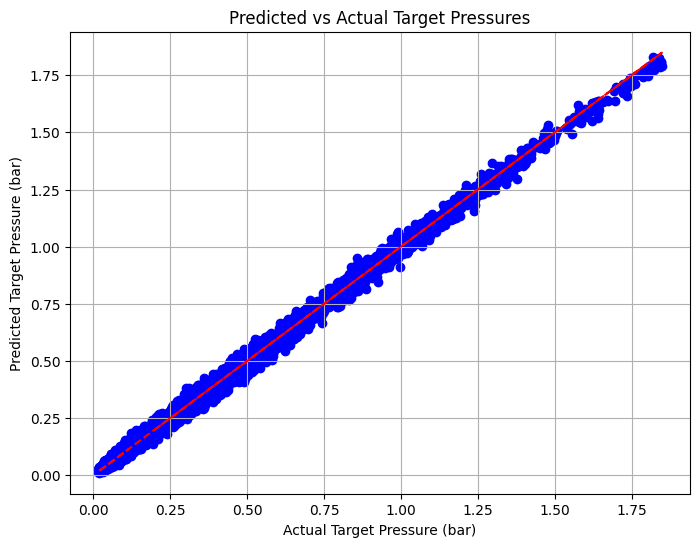

In [9]:
# XG boost regression

from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, eta=0.1, max_depth=7, subsample=0.5, random_state=42)
xgb.fit(X, Y)

xgb_predicted = xgb.predict(X)
feature_ranking = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

r_square_score = xgb.score(X, Y)
mape = mean_absolute_percentage_error(Y, xgb_predicted)
mae = mean_absolute_error(Y, xgb_predicted)
rmse = mean_squared_error(Y, xgb_predicted, squared=False)

print('XG boosting regreesion R squared : {:.6f}'.format(r_square_score))
print('XG boosting Mean Absolute Percentage Error : {:.5f}'.format(mape))
print('XG boosting Mean Absolute Error : {:.5f}'.format(mae))
print('XG boosting Root Mean Squared Error : {:.5f}'.format(rmse))

print("\nFeature ranking : ")
print(feature_ranking)

test_xgb_predicted_values = xgb.predict(test_data)
test_xgb_predicted_df = pd.DataFrame(test_xgb_predicted_values, columns=['Target Pressure (bar)'])
xgb_prediction = pd.concat([test_id, test_xgb_predicted_df], axis=1)
xgb_prediction.to_csv('xgb_prediction.csv', index=False)

# Plotting predicted vs actual target values
plt.figure(figsize=(8, 6))
plt.scatter(Y, xgb_predicted, color='blue', label='Predicted vs Actual Target Pressures')
plt.plot(Y, Y, color='red', linestyle='--', label='') 
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.title('Predicted vs Actual Target Pressures')
plt.grid(True)
plt.show()


In [269]:
# Multiple xgb models : 

from sklearn.ensemble import VotingRegressor

ensembled_regessor = VotingRegressor(estimators=[('xgb', xgb), ('tuned_gbr', tuned_gbr)])
ensembled_regessor.fit(X, Y)
final_predicted_values = ensembled_regessor.predict(X)

final_xgb_r_square_score = ensembled_regessor.score(X, Y)
final_xgb_mape = mean_absolute_percentage_error(Y, final_predicted_values)
final_xgb_mae = mean_absolute_error(Y, final_predicted_values)
final_xgb_rmse = mean_squared_error(Y, final_predicted_values, squared=False)

print('Final XG boosting regreesion R squared : {:.6f}'.format(final_xgb_r_square_score))
print('Final XG boosting Mean Absolute Percentage Error : {:.5f}'.format(final_xgb_mape))
print('Final XG boosting Mean Absolute Error : {:.5f}'.format(final_xgb_mae))
print('Final XG boosting Root Mean Squared Error : {:.5f}'.format(final_xgb_rmse))

test_final_predicted_values = ensembled_regessor.predict(test_data)

test_final_predicted_df = pd.DataFrame(test_final_predicted_values, columns=['Target Pressure (bar)'])
final_xgb_prediction = pd.concat([test_id, test_final_predicted_df], axis=1)
final_xgb_prediction.to_csv('ensembled_regressor_prediction.csv', index=False)


/Users/kalinduabeysinghe/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Final XG boosting regreesion R squared : 0.999886
Final XG boosting Mean Absolute Percentage Error : 0.01747
Final XG boosting Mean Absolute Error : 0.00258
Final XG boosting Root Mean Squared Error : 0.00329


Support Vector Regression 

/Users/kalinduabeysinghe/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM regreesion R squared : 0.826152
SVM regression Mean Absolute Percentage Error : 0.44276
SVM regression Mean Absolute Error : 0.08198
SVM regression Root Mean Squared Error : 0.12843


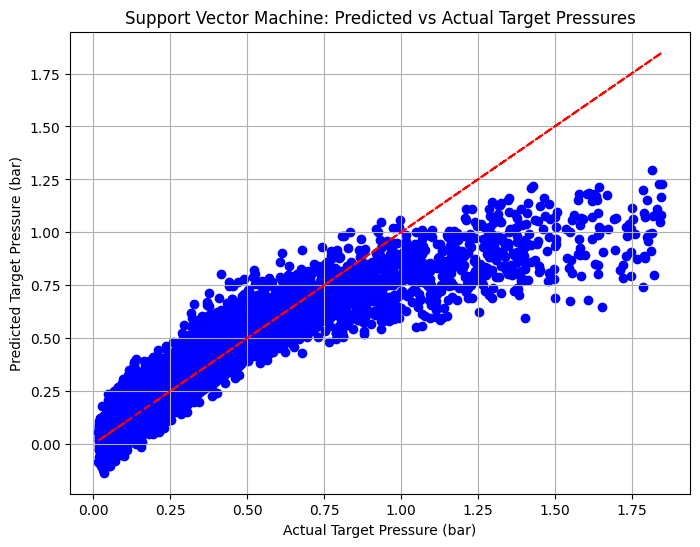

In [270]:
# Support Vector Machine Regression

from sklearn import svm
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

svm_regression= svm.SVR()
svm_regression.fit(X, Y)
svm_predicted = svm_regression.predict(X)   

r_square_score = svm_regression.score(X, Y)
svm_mape = mean_absolute_percentage_error(Y, svm_predicted)
svm_mae = mean_absolute_error(Y, svm_predicted)
svm_rmse = mean_squared_error(Y, svm_predicted, squared=False)

print('SVM regreesion R squared : {:.6f}'.format(r_square_score))
print('SVM regression Mean Absolute Percentage Error : {:.5f}'.format(svm_mape))
print('SVM regression Mean Absolute Error : {:.5f}'.format(svm_mae))
print('SVM regression Root Mean Squared Error : {:.5f}'.format(svm_rmse))
      
# Plotting predicted vs actual target values
plt.figure(figsize=(8, 6))
plt.scatter(Y, svm_predicted, color='blue', label='SVM Predicted vs Actual Target Pressures')
plt.plot(Y, Y, color='red', linestyle='--', label='') 
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.title('Support Vector Machine: Predicted vs Actual Target Pressures')
plt.grid(True)
plt.show()



In [271]:
# Hyper parameter tuning for Support Vector regression

param_grid = { 
    'C':[1,100,1000],
    'kernel':['rbf','poly'],
    'degree':[1,2,3,4,5,6]
}
search_grid = GridSearchCV(svm_regression,param_grid)

'''Commenting this out since this takes a very long time'''
# search_grid.fit(X,Y)

# print('Best parameters for SVM : ', search_grid.best_params_)
# print('Best score for SVM : ', search_grid.best_score_)

'Commenting this out since this takes a very long time'

Neural network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               7936      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 gaussian_noise_1 (Gaussian  (None, 256)               0         
 Noise)                                                          
                                                                 
 dense_7 (Dense)             (None, 128)               33024     
                                                                 
 dense_8 (Dense)             (None, 64)                8320      
                                                                 
 dense_9 (Dense)             (None, 32)                2112      
                                                      

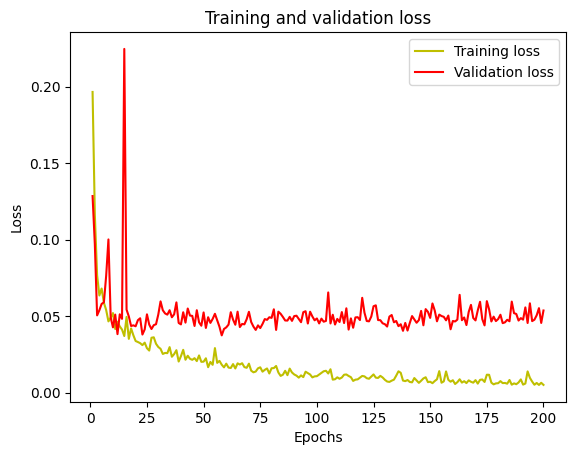

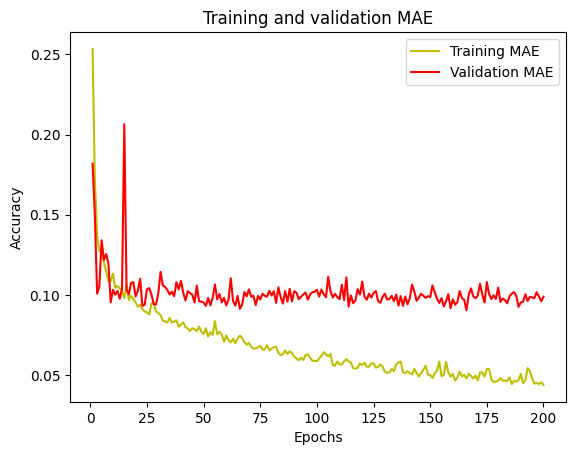

291/291 [==============================] - 0s 401us/step
Neural network R squared : 0.752058
0.7520584721950079
Neural network regression Mean Absolute Percentage Error : 0.25495
Neural network Mean Absolute Error : 0.06911
Neural network Root Mean Squared Error : 0.15338
101/101 [==============================] - 0s 347us/step


In [272]:
# Neural network model

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, PReLU, Dropout, Embedding, ActivityRegularization, Normalization, GaussianNoise
from keras.optimizers import Adam, Nadam, AdamW, Ftrl
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

nn_model = Sequential()
nn_model.add(Dense(256, input_dim=X_nn.columns.size, activation=PReLU()))
nn_model.add(Dropout(0.2))
nn_model.add(GaussianNoise(0.05))
nn_model.add(Dense(128, activation=PReLU()))
nn_model.add(Dense(64, activation=PReLU()))
nn_model.add(Dense(32, activation=PReLU()))
nn_model.add(Dense(16, activation=PReLU()))
nn_model.add(Dense(1, activation='linear'))

nn_optmizier = Nadam(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

nn_model.compile(loss='mean_squared_error', 
                 optimizer= nn_optmizier,
                 metrics=['mae'])
nn_model.summary()

history = nn_model.fit(X_nn, Y_nn, epochs=200, validation_split=0.2, batch_size=32)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

nn_predicted = nn_model.predict(X)

r_square_score = r2_score(Y, nn_predicted)
nn_mape = mean_absolute_percentage_error(Y, nn_predicted)
nn_mae = mean_absolute_error(Y, nn_predicted)
nn_rmse = mean_squared_error(Y, nn_predicted, squared=False)

print('Neural network R squared : {:.6f}'.format(r_square_score))
print(r_square_score)
print('Neural network regression Mean Absolute Percentage Error : {:.5f}'.format(nn_mape))
print('Neural network Mean Absolute Error : {:.5f}'.format(nn_mae))
print('Neural network Root Mean Squared Error : {:.5f}'.format(nn_rmse))


test_nn_predicted_values = nn_model.predict(test_data)
test_nn_predicted_df = pd.DataFrame(test_nn_predicted_values, columns=['Target Pressure (bar)'])
nn_prediction = pd.concat([test_id, test_nn_predicted_df], axis=1)
nn_prediction.to_csv('nn_prediction.csv', index=False)


In [273]:
# Keras tuning

from keras.layers import Dense, LeakyReLU, PReLU, Dropout, Activation, LSTM
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=1),
                    input_dim=X_train.columns.size,
                    activation=PReLU()))
    model.add(Dropout(0.1))
    model.add(GaussianNoise(0.05))
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=128, step=1),
                    activation=PReLU()))
    model.add(Dense(units=hp.Int('units_3', min_value=1, max_value=64, step=1),
                    activation=PReLU()))
    model.add(Dense(units=hp.Int('units_4', min_value=1, max_value=32, step=1),
                    activation=PReLU()))
    model.add(Dense(units=hp.Int('units_5', min_value=1, max_value=16, step=1),
                    activation=PReLU()))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Nadam(
            hp.Choice('learning_rate', values=[0.01, 0.001]), 
            hp.Choice('weight_decay', values=[0.004, 0.0004]),
            hp.Choice('epsilon', values=[1e-06, 1e-07, 1e-08]),
            hp.Choice('beta_1', values=[0.9, 0.99]),
            hp.Choice('beta_2', values=[0.999, 0.9999])),
        loss='mean_squared_error',
        metrics=['mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='hyperparameter_tuning',
    project_name='regression_nn')


tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)


Reloading Tuner from hyperparameter_tuning/regression_nn/tuner0.json


Best Hyperparameters:
{'units_1': 156, 'units_2': 52, 'units_3': 29, 'units_4': 23, 'units_5': 12, 'learning_rate': 0.01, 'weight_decay': 0.0004, 'epsilon': 1e-06, 'beta_1': 0.9, 'beta_2': 0.999}


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 156)               4836      
                                                                 
 dropout_1 (Dropout)         (None, 156)               0         
                                                                 
 gaussian_noise_1 (Gaussian  (None, 156)               0         
 Noise)                                                          
                                                                 
 dense_7 (Dense)             (None, 52)                8216      
                                                                 
 dense_8 (Dense)             (None, 29)                1566      
                                                                 
 dense_9 (Dense)             (None, 23)                713       
                                                      

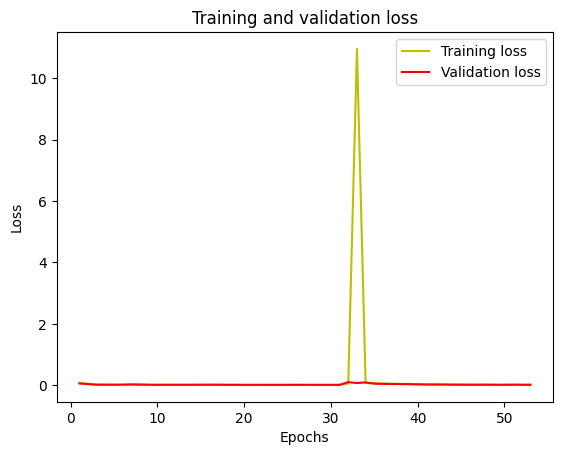

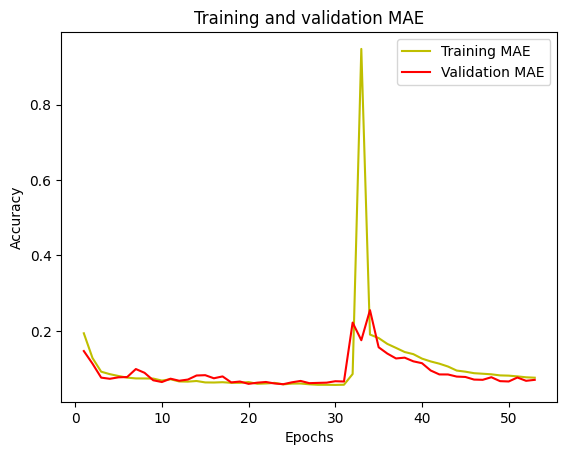

291/291 [==============================] - 0s 322us/step - loss: 0.0065 - mae: 0.0528
Tuned Neural network R squared : 0.931419
Tuned Neural network regression Mean Absolute Percentage Error : 0.24866
Tuned Neural network Mean Absolute Error : 0.05281
Tuned Neural network Root Mean Squared Error : 0.08067
101/101 [==============================] - 0s 275us/step


In [274]:
# Tuned Neural network: 

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, PReLU, Dropout, Embedding, ActivityRegularization, LayerNormalization, GaussianNoise
from keras.optimizers import Adam, Nadam, AdamW, Ftrl
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

nn_model = Sequential()
nn_model.add(Dense(156, input_dim=X_nn.columns.size, activation=PReLU(
    alpha_initializer="Zeros",
    alpha_regularizer=None,
    alpha_constraint=None,
    shared_axes=None
)))
nn_model.add(Dropout(0.1))
nn_model.add(GaussianNoise(0.05))
nn_model.add(Dense(52, activation=PReLU(
    alpha_initializer="Zeros",
    alpha_regularizer=None,
    alpha_constraint=None,
    shared_axes=None
)))
nn_model.add(Dense(29, activation=PReLU(
    alpha_initializer="Zeros",
    alpha_regularizer=None,
    alpha_constraint=None,
    shared_axes=None
)))
nn_model.add(Dense(23, activation=PReLU(
    alpha_initializer="Zeros",
    alpha_regularizer=None,
    alpha_constraint=None,
    shared_axes=None
)))
nn_model.add(Dense(12, activation=PReLU(
    alpha_initializer="Zeros",
    alpha_regularizer=None,
    alpha_constraint=None,
    shared_axes=None
)))
nn_model.add(Dense(1, activation='linear'))
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

nn_model.compile(loss='mean_squared_error', 
                 optimizer=Nadam(
                    learning_rate=0.01,
                    weight_decay=0.0004,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-06,
                    ), 
                 metrics=['mae'])
nn_model.summary()

history = nn_model.fit(X, Y, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

nn_predicted = nn_model.predict(X)

r_square_score = nn_model.evaluate(X, Y)
nn_mape = mean_absolute_percentage_error(Y, nn_predicted)
nn_mae = mean_absolute_error(Y, nn_predicted)
nn_rmse = mean_squared_error(Y, nn_predicted, squared=False)

r_square_score = r2_score(Y, nn_predicted)
print('Tuned Neural network R squared : {:.6f}'.format(r_square_score))
print('Tuned Neural network regression Mean Absolute Percentage Error : {:.5f}'.format(nn_mape))
print('Tuned Neural network Mean Absolute Error : {:.5f}'.format(nn_mae))
print('Tuned Neural network Root Mean Squared Error : {:.5f}'.format(nn_rmse))

test_nn_predicted_values = nn_model.predict(test_data)
test_nn_predicted_df = pd.DataFrame(test_nn_predicted_values, columns=['Target Pressure (bar)'])
nn_prediction = pd.concat([test_id, test_nn_predicted_df], axis=1)
nn_prediction.to_csv('nn_tuned_prediction.csv', index=False)